In [1]:
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import networkx as nx
import community
import pandas as pd

import numpy as np
import json


In [3]:
import collections

In [4]:
from networkx.algorithms.community import greedy_modularity_communities


In [5]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file, test_kruskal


In [6]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.lines as lines

font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [7]:
df = pd.read_csv("../data/prisoners_dilemma_articles_meta_data_clean.csv")


In [8]:
periods = np.sort(df["date"].unique())
periods = periods[~np.isnan(periods)]
periods = periods[1:]

 Collaborativeness 
---------------------------

In [9]:
graph = nx.read_gml("../data/networks/pd_new_graph.gml")

Illustrating co-authors network
------------------------

**Use Gephi**

Network Metrics
-----------------------

In [10]:
number_edges = nx.number_of_edges(graph)
number_nodes = nx.number_of_nodes(graph)


In [11]:
for filename, metric in zip(["pd_edges.txt", "pd_unique_authors.txt"],
                            [number_edges, number_nodes]
):
    write_to_file(filename=filename, metric=metric)


In [12]:
def fix_names_for_table(name):
    name = name.title()
    return name



Collaborative Behaviour
-----------------------------

In [13]:
def collaborative_metrics_of_graph(graph):
    """
    Returns the following metrics:
    - number of nodes
    - number of edges
    - number of isolated authors
    - percentage of isolated authors
    - number of connected components
    - size of the largest connected component
    - average degree
    - clustering coefficients
    - modularity
    """
    num_nodes = nx.number_of_nodes(graph)
    num_edges = nx.number_of_edges(graph)
    isolated_nodes = len(list(nx.isolates(graph)))
    percentage_isolated_nodes = np.round(isolated_nodes / num_nodes, 3) * 100
    number_connected_components = nx.number_connected_components(graph)
    size_of_largest_cc = len(max(nx.connected_components(graph), key=len))

    degree_distribution = sorted([d for n, d in graph.degree()], reverse=True)
    av_degree = np.round(np.mean(degree_distribution), 3)

    clustering_coeff = round(nx.average_clustering(graph), 3)

    try:
        number_of_communities = len(list(greedy_modularity_communities(graph)))
    except ZeroDivisionError:
        number_of_communities = "-"

    communities = community.best_partition(graph)
    try:
        modularity = community.modularity(partition=communities, graph=graph)
    except ValueError:
        modularity = "-"

    metrics = {
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "# Isolated nodes": isolated_nodes,
        "% Isolated nodes": round(percentage_isolated_nodes, 3),
        "# Connected components": number_connected_components,
        "Size of largest component": size_of_largest_cc,
        "Av. degree": av_degree,
        "Clustering coeff": clustering_coeff,
        "# Communities": number_of_communities,
        "Modularity": modularity,
    }

    return metrics, degree_distribution


**Network Metrics**

In [14]:
metrics = collaborative_metrics_of_graph(graph)[0]


In [15]:
metrics


{'# Nodes': 4011,
 '# Edges': 7642,
 '# Isolated nodes': 128,
 '% Isolated nodes': 3.2,
 '# Connected components': 947,
 'Size of largest component': 796,
 'Av. degree': 3.811,
 'Clustering coeff': 0.701,
 '# Communities': 967,
 'Modularity': 0.9655750881110567}

In [16]:
degree_dstrs = collaborative_metrics_of_graph(graph)[1]

In [17]:
# for key in metrics:
#     filename = key.replace(" ", "_").replace("#", "num").replace("%", "perce") + ".txt"
#     write_to_file(filename, metrics[key])


**Analysing clusters**

In [20]:
center_cluster = max(nx.connected_component_subgraphs(graph), key=len)


In [21]:
center_cluster_metrics = collaborative_metrics_of_graph(center_cluster)[0]


In [22]:
center_cluster_degrees = collaborative_metrics_of_graph(center_cluster)[1]



**Tables**

In [23]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]


In [24]:
metrics_table = pd.DataFrame.from_dict([metrics, center_cluster_metrics])
metrics_table.index = [r"$G$", r"$\bar{G}$"]

In [26]:
metrics_table = metrics_table[columns_order]

In [27]:
write_to_file(metric=metrics_table.to_latex(), filename="network_comparison.tex")


**Degree Distribution**

In [25]:
max(degree_dstrs)


59

In [26]:
colors = [None, "darkgreen"]
labels = [r'$G$', r'$\bar{G}$']

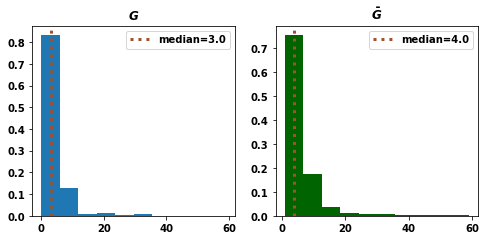

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))

for i, measure in enumerate([degree_dstrs, center_cluster_degrees]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="sienna",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")
    axes[i].set_title(labels[i])

    axes[i].legend();

plt.savefig("../../assets/images/networks_ditributions.pdf")


In [28]:
temp = pd.DataFrame(degree_dstrs)
temp.describe()

,0
count,4011.000000
mean,3.810521
std,4.415118
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,59.000000


Cumulative Graphs
---------

In [29]:
linestyle = [":o", "-.", "--"]


In [30]:
import glob


In [31]:
years = sorted(df.date.unique())

In [32]:
cumulative_graphs = []
for year in years[:-1]:
    cumulative_graphs.append(nx.read_gml(f"../data/networks/yearly/G_pd_{int(year)}.gml"))


In [33]:
len(cumulative_graphs)

57

In [34]:
cumulative_clusters = [max(nx.connected_component_subgraphs(G), key=len) for G in cumulative_graphs[6:]]


In [35]:
len(cumulative_graphs), len(cumulative_clusters)


(57, 51)

In [36]:
cumulative_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_graphs[6:]
]


In [37]:
cumulative_cluster_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_clusters]


In [38]:
len(cumulative_cluster_metrics)

51

**Tables**

In [39]:
# with open("../../assets/periods_dictionary.json") as json_file:
#     periods_dictionary = json.load(json_file)

In [40]:
cumulative_table = pd.DataFrame.from_dict(cumulative_metrics).round(3)
cumulative_table = cumulative_table[columns_order]


In [41]:
cumulative_table.head(15)


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
0,6,3,0,0.0,3,2,1.000,3,0.667,0.000
1,8,4,0,0.0,4,2,1.000,4,0.750,0.000
2,19,15,0,0.0,8,5,1.579,8,0.684,0.228
3,20,17,0,0.0,8,6,1.700,8,0.630,0.250
4,22,18,0,0.0,9,6,1.636,9,0.667,0.227
5,33,28,0,0.0,13,6,1.697,13,0.827,0.424
6,39,34,0,0.0,15,6,1.744,15,0.867,0.513
7,42,35,1,2.4,17,6,1.667,17,0.873,0.476
8,42,35,1,2.4,17,6,1.667,17,0.873,0.476
9,42,35,1,2.4,17,6,1.667,17,0.873,0.476


In [42]:
cumulative_table.describe()

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,616.352941,949.588235,28.960784,5.468627,181.529412,82.921569,1.973294,183.352941,0.911706,0.452000
std,1038.107525,1893.650519,37.154252,3.989661,260.653897,188.097086,0.706136,264.912501,0.088772,0.144216
min,6.000000,3.000000,0.000000,0.000000,3.000000,2.000000,1.000000,3.000000,0.630000,0.000000
25%,47.000000,40.000000,1.000000,2.400000,18.000000,6.000000,1.603000,18.000000,0.884000,0.398500
50%,106.000000,81.000000,12.000000,4.400000,47.000000,6.000000,1.693000,47.000000,0.947000,0.454000
75%,586.000000,539.500000,42.000000,8.450000,230.000000,20.500000,1.862000,230.000000,0.969500,0.505000
max,4011.000000,7642.000000,128.000000,12.900000,947.000000,796.000000,3.811000,967.000000,0.987000,0.701000


In [43]:
# write_to_file(
#     metric=cumulative_table.to_latex(), filename="cumulative_graphs_table.tex"
# )


In [44]:
clusters_cum_table = pd.DataFrame.from_dict(cumulative_cluster_metrics).round(3)
clusters_cum_table = clusters_cum_table[columns_order]


In [45]:
# write_to_file(
#     metric=clusters_cum_table.to_latex(), filename="cumulative_clusters_table.tex"
# )


**Centralities**

In [46]:
betweeness = sorted(nx.betweenness_centrality(graph).items(), key=lambda x: x[1], reverse=True)
closeness = sorted(nx.closeness_centrality(graph).items(), key=lambda x: x[1], reverse=True)

In [47]:
betweeness_cluster = sorted(nx.betweenness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)
closeness_cluster = sorted(nx.closeness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)

In [48]:
labels = ['Betweenness', 'Closeness']

In [49]:
tables = []
for i, measure in enumerate([betweeness, closeness, betweeness_cluster, closeness_cluster]):
    table = pd.DataFrame(measure[:10], columns=["Name", labels[int(i % 2)]])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table)     


In [50]:
# write_to_file(
#     metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="centralities_pd_graph.tex"
# )

**Distributions**

In [51]:
distributions_betweeness = [point[1] for point in betweeness]
distributions_closeness = [point[1] for point in closeness]

In [52]:
distributions_betweeness_cluster = [point[1] for point in betweeness_cluster]
distributions_closeness_cluster = [point[1] for point in closeness_cluster]

In [71]:
colors = ['darkgray', 'darkorange']

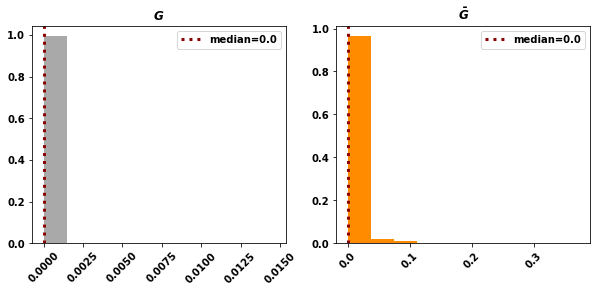

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
labels = [r'$G$', r'$\bar{G}$']


for i, measure in enumerate([distributions_betweeness, distributions_betweeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")

    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
    
    axes[i].set_title(labels[i])

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_betweeness_centralities.pdf", bbox_inches='tight')

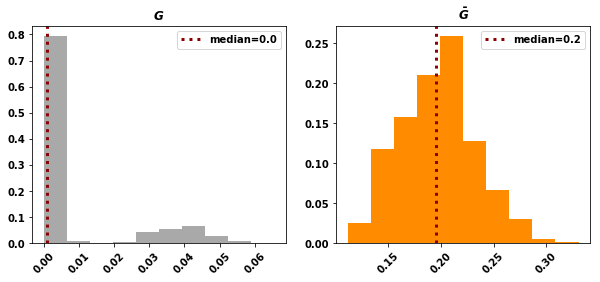

In [80]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, measure in enumerate([distributions_closeness,
                                  distributions_closeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(labels[i])
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_closeness_centralities.pdf", bbox_inches='tight')

Topics
=====

In [55]:
data_with_topics = pd.read_csv('../data/prisoners_dilemma_meta_data_with_topics.csv')

In [56]:
names = df['author']

In [57]:
names = [tools.normalise_name(name) for name in names]

In [58]:
data_with_topics['author_standarized'] = names

In [59]:
counts = data_with_topics[['author_standarized',
                           'Dominant_Topic']].drop_duplicates().groupby('author_standarized').count()

In [60]:
len(counts[counts.values == 1])

2246

In [61]:
len(counts[counts.values > 1])

1975

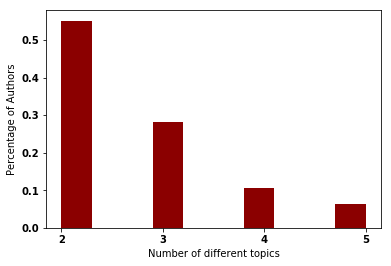

In [62]:
fig, ax = plt.subplots()

measure = counts[counts['Dominant_Topic'] > 1].values

weights = np.ones_like(measure) / float(len(measure))

ax.hist(measure, weights=weights, color='darkred')
ax.set_xticks([2, 3, 4, 5]);

ax.set_xlabel('Number of different topics');
ax.set_ylabel('Percentage of Authors');

plt.savefig("../../assets/images/percentage_of_authors_different_topic.pdf", bbox_inches="tight")

In [63]:
total = len(counts[counts['Dominant_Topic'] == 2].values)

In [64]:
replace = {'0.0': 'A',
           '1.0': 'B',
           '2.0': 'C',
           '3.0': 'D',
           '4.0': 'E',
          }

In [65]:
labels = ['A', 'B', 'C', 'D', 'E']

In [66]:
from_ = []
to_ = []
values = []
for number in range(2, 6):
    total = len(counts[counts['Dominant_Topic'] == number].values)
    topics = []
    for name in counts[counts['Dominant_Topic'] == number].index:
        groups = data_with_topics[data_with_topics['author_standarized'] == name]['Dominant_Topic'].unique()
        topics.append(groups)
    topics = [tuple(topic) for topic in topics]
    counter = collections.Counter(tuple(sorted(tup)) for tup in topics)

    for key in counter.keys():
        from_.append(str([labels[int(i)] for i in key]))
        
        values.append(round(counter[key] / total, 2))

In [67]:
# write_to_file(metric=pd.DataFrame({'From': from_,
#               'Probabilities': values}).replace(replace).to_latex(), filename="topic_probabilities.tex")
              

In [68]:
authors_that_write_in_many_topics = counts[counts['Dominant_Topic'] > 1].index

In [69]:
for i in range(2, 5):
    isolated = list(nx.isolates(graphs[i]))
    print(sum([author in authors_that_write_in_many_topics for author in isolated]) / len(isolated))

NameError: name 'graphs' is not defined

In [ ]:
[graphs[3].edges(author) for author in authors_that_write_in_many_topics]

In [ ]:
isolated

**Graphs**

In [83]:
graphs = []
number_of_topics = 5
for number in range(number_of_topics):
    graphs.append(nx.read_gml(f'../data/networks/topic_{int(number)}_pd_.gml'))

In [84]:
number_edges = [nx.number_of_edges(G) for G in graphs]
number_nodes = [nx.number_of_nodes(G) for G in graphs]

In [85]:
metrics = [collaborative_metrics_of_graph(G)[0] for G in graphs]

In [86]:
degree_dstrs = [collaborative_metrics_of_graph(G)[1] for G in graphs]

In [87]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]

In [88]:
topics = ["Topic A", "Topic B", "Topic C", "Topic D", "Topic E"]

In [89]:
metrics_table = pd.DataFrame.from_dict(metrics).round(3)
metrics_table.index = topics

In [90]:
metrics_table

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,Clustering coeff,# Communities,Modularity
Topic A,1124,2137,15,1.3,264,56,3.802,0.759,265,0.983
Topic B,695,1382,13,1.9,157,80,3.977,0.773,158,0.950
Topic C,900,1141,41,4.6,281,29,2.536,0.636,281,0.981
Topic D,880,1509,17,1.9,174,312,3.430,0.701,183,0.920
Topic E,1045,1964,59,5.6,354,31,3.759,0.664,354,0.926


In [91]:
metrics_table = metrics_table[columns_order]

In [92]:
# write_to_file(metric=metrics_table.to_latex(), filename="topic_network_comparison.tex")

In [93]:
betweeness = [
    sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]



In [94]:
closeness = [
    sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]


In [95]:
tables = []
for measure in betweeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Betweeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [96]:
pd.concat(tables, axis=1)

,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness
1,David Rand,0.001570,Long Wang,0.006306,Daniel Ashlock,0.000655,Matjaz Perc,0.063534,Zengru Di,0.000096
2,Valerio Capraro,0.001252,Luo-Luo Jiang,0.004566,Matjaz Perc,0.000453,Luo-Luo Jiang,0.036631,Jian Yang,0.000033
3,Angel Sanchez,0.000555,Martin Nowak,0.004203,Karl Tuyls,0.000436,Yamir Moreno,0.031429,Yevgeniy Vorobeychik,0.000026
4,Feng Fu,0.000533,Matjaz Perc,0.003476,Philip Hingston,0.000327,Christoph Hauert,0.027449,Otavio Teixeira,0.000022
5,Martin Nowak,0.000484,Attila Szolnoki,0.002707,Eun-Youn Kim,0.000286,Long Wang,0.024083,Roberto Oliveira,0.000022
6,Nicholas Christakis,0.000350,Christian Hilbe,0.002362,Wendy Ashlock,0.000260,Zhen Wang,0.023949,M. Nowak,0.000020
7,Pablo Branas-Garza,0.000340,Yamir Moreno,0.002362,Attila Szolnoki,0.000225,Han-Xin Yang,0.022656,M. Harper,0.000011
8,Toshio Yamagishi,0.000305,Xiaojie Chen,0.002170,Seung Baek,0.000216,Martin Nowak,0.019746,Xiao Han,0.000011
9,James Fowler,0.000300,Arne Traulsen,0.001950,Martin Nowak,0.000211,Angel Sanchez,0.016911,Zhesi Shen,0.000011
10,Long Wang,0.000248,Zhen Wang,0.001821,Thore Graepel,0.000193,Zhihai Rong,0.015619,Wen-Xu Wang,0.000011


In [97]:
# write_to_file(
#     metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="betweeness_topics_graphs.tex"
# )

In [98]:
tables = []
for measure in closeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Closeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [99]:
# write_to_file(
#     metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="closeness_topics_graphs.tex"
# )

In [100]:
distributions_betweeness = [[point[1] for point in coeff] for coeff in betweeness]

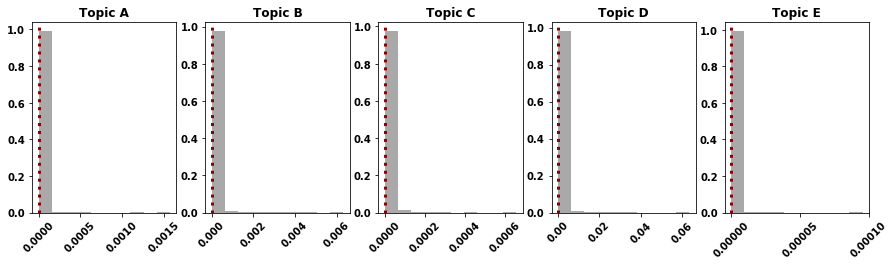

In [119]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3.5))

for i, measure in enumerate(distributions_betweeness):

    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[0])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(topics[i], fontweight='bold')
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.savefig("../../assets/images/topics_betweeness_distributions.pdf", bbox_inches="tight")

In [116]:
# fig, axes = plt.subplots(figsize=(10, 5))
# plt.violinplot(distributions_betweeness)
# boxes = plt.boxplot(distributions_betweeness, showfliers=False)

# for bp in boxes['medians']:
#     bp.set_color('red')
#     bp.set_linewidth(2)
#     bp.set_linestyle('-.')
# for bp in boxes['caps']:
#     bp.set_color('black')
#     bp.set_linewidth(2)
# for bp in boxes['whiskers']:
#     bp.set_color('black')
#     bp.set_linewidth(2)
# for bp in boxes['boxes']:
#     bp.set_color('black')
#     bp.set_linewidth(2)

# # axes.set_ylim([0, 0.02]);
# axes.set_ylabel('Betweeness Centrality')
# axes.set_xticks(range(1, 6))
# axes.set_xticklabels(topics);

# plt.savefig("../../assets/images/topics_betweeness_distributions.pdf", bbox_inches="tight")

In [117]:
distributions_close = [[point[1] for point in coeff] for coeff in closeness]


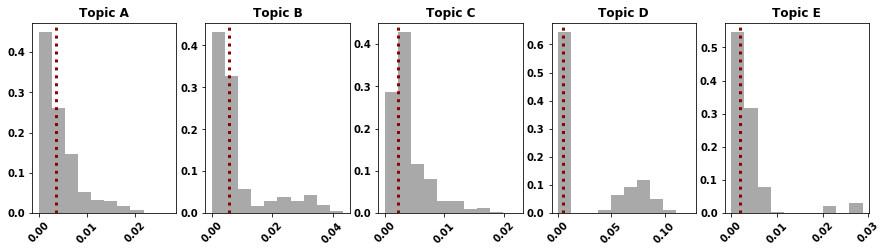

In [120]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3.5))

for i, measure in enumerate(distributions_close):

    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[0])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(topics[i], fontweight='bold')
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.savefig("../../assets/images/topics_closeness_distributions.pdf", bbox_inches="tight")

In [121]:
# fig, axes = plt.subplots(figsize=(10, 5))
# plt.violinplot(distributions_close)
# boxes = plt.boxplot(distributions_close, showfliers=False)

# for bp in boxes['medians']:
#     bp.set_color('red')
#     bp.set_linewidth(2)
#     bp.set_linestyle('-.')
# for bp in boxes['caps']:
#     bp.set_color('black')
#     bp.set_linewidth(2)
# for bp in boxes['whiskers']:
#     bp.set_color('black')
#     bp.set_linewidth(2)
# for bp in boxes['boxes']:
#     bp.set_color('black')
#     bp.set_linewidth(2)

# # axes.set_ylim([0, 0.01]);
# axes.set_ylabel('Closeness Centrality')
# axes.set_xticks(range(1, 6))
# axes.set_xticklabels(topics);

# plt.savefig("../../assets/images/topics_closeness_distributions.pdf", bbox_inches="tight")